In [14]:
import pandas as pd
import herepy
from tqdm.notebook import tqdm
from collections import defaultdict
import re
import requests
import urllib
import xmltodict
import json
import numpy as np
#packages for R in python
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
#CPD
from pgmpy.models import BayesianModel
import pgmpy
# from pgmpy.estimators import ConstraintBasedEstimator
#bnlearn
import bnlearn
import torch
import pyro
import pyro.distributions as dist
from statistics import mean
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import Image

%matplotlib inline

In [15]:
listings_full = pd.read_csv('data/listings_full.csv')

In [16]:
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

def herePy(coordinate1,coordinate2):
    coordinates = coordinate1+','+coordinate2
    locator = Nominatim(user_agent="myGeocoder")
    address = locator.reverse(coordinates)
    address = address.raw
    return pd.Series([address.get('display_name',None),
                      address['address'].get('house_number',address['address'].get('building',None)),
                      address['address'].get('road',None),
                      address['address'].get('country',None),
                      address['address'].get('postcode',None)],
                     index=['Address','House','Street','Country',
                            'PostalCode'])

In [17]:
tqdm.pandas()

listings_full[['Address','HouseNumber','Street','Country','PostalCode']] = listings_full.progress_apply(lambda row: herePy(str(row['latitude']), str(row['longitude'])) , axis=1)

/Users/abdulrehman/opt/anaconda3/envs/Airbnb_Analysis/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [18]:
listings_full['Street'].unique()

array(['Boston Street', 'Goodrich Road', 'Salem Street',
       'Winthrop Street', 'Easton Street', 'Clive Street', 'I Street',
       'Sawyer Avenue', 'Alameda Road', 'Green Street', 'Waltham Street',
       'Orchardhill Road', 'Hanover Street', 'Isabella Street',
       'Marlborough Street', 'Thornton Street', 'Quint Avenue',
       'Massachusetts Avenue', 'West Canton Street', 'Charles Street',
       'Corey Road', 'Centre Street', 'Weld Hill Street',
       'Worcester Square', 'Commonwealth Avenue Frontage Road Wb',
       'Beacon Street', 'Temple Street', 'Bond Street', 'Phillips Street',
       'Tremont Street', 'Pinckney Street', 'Bennington Street',
       'Peterborough Street', 'Commonwealth Avenue', 'Edgerly Road',
       'Columbus Avenue', 'Appleton Street', 'Park Lane',
       'Washington Street', 'Business Street', 'Blue Hill Avenue',
       'Sumner Street', 'Byron Street', 'Geneva Avenue', 'Larch Street',
       'Haynes Street', 'Hardwick Street', 'Monadnock Street',
    

In [19]:
listings_subset = listings_full[['id','Zestimate','bedrooms','bathrooms','beds','accommodates','amenities_score',
               'bikeScore','walkScore','transitScore','neighbourhood_cleansed','property_type',
               'publicSchoolScores','closenessToDowntown','price','minimum_nights_avg_ntm','roi','Street']]

pd.options.mode.chained_assignment = None
listings_subset['property_type'] = listings_subset['property_type'].astype('category')
listings_subset['bathrooms'] = listings_subset['bathrooms'].astype('category')
listings_subset['neighbourhood'] = listings_subset['neighbourhood_cleansed'].astype('category')
listings_subset['street'] = listings_subset['Street'].astype('category')
del listings_subset['neighbourhood_cleansed']
del listings_subset['Street']

listings_subset['roi'] = listings_subset['roi'].astype('float')
listings_subset['Zestimate'] = listings_subset['Zestimate'].astype('float')
listings_subset['bedrooms'] = listings_subset['bedrooms'].astype('float')
listings_subset['beds'] = listings_subset['beds'].astype('float')
listings_subset['accommodates'] = listings_subset['accommodates'].astype('float')
listings_subset['amenities_score'] = listings_subset['amenities_score'].astype('float')
listings_subset['publicSchoolScores'] = listings_subset['publicSchoolScores'].astype('float')
listings_subset['closenessToDowntown'] = listings_subset['closenessToDowntown'].astype('float')
listings_subset['price'] = listings_subset['price'].astype('float')
listings_subset['minimum_nights_avg_ntm'] = listings_subset['minimum_nights_avg_ntm'].astype('float')
pd.options.mode.chained_assignment = 'warn'

In [20]:
listing_cat = listings_subset[['bathrooms','bikeScore','walkScore','transitScore','property_type','neighbourhood','street']]
listings_n_cat = listings_subset[['roi','Zestimate','bedrooms','beds','accommodates','amenities_score','publicSchoolScores','closenessToDowntown','price','minimum_nights_avg_ntm']]

In [21]:
def rDiscretize(data):
    utils = importr('utils')
    utils.install_packages('bnlearn')
    # utils.install_packages('base')
    bnlearnR = importr('bnlearn')
    bnDiscretize = bnlearnR.discretize
    # Import Functions
    pandas2ri.activate()
    r_dt = ro.conversion.py2rpy(data) #convert pandas to RDataframe
    r_dt2 = bnDiscretize(r_dt,method= "hartemink", breaks = 3, ibreaks=3)
    pd_dt = ro.conversion.rpy2py(r_dt2)
    pd_dt.reset_index(drop=True)
    return pd_dt

In [22]:
listings_fac = rDiscretize(listings_n_cat)

--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Australia (Perth) [https]
 6: Austria [https]
 7: Belgium (Ghent) [https]
 8: Brazil (BA) [https]
 9: Brazil (PR) [https]
10: Brazil (RJ) [https]
11: Brazil (SP 1) [https]
12: Brazil (SP 2) [https]
13: Bulgaria [https]
14: Canada (MB) [https]
15: Chile (Santiago) [https]
16: China (Beijing 2) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Guangzhou) [https]
20: China (Lanzhou) [https]
21: China (Nanjing) [https]
22: China (Shanghai 1) [https]
23: China (Shanghai 2) [https]
24: Costa Rica [https]
25: Denmark [https]
26: East Asia [https]
27: Ecuador (Cuenca) [https]
28: Ecuador (Quito) [https]
29: Estonia [https]
30: France (Lyon 1) [https]
31: France (Lyon 2) [https]
32: France (Marseille) [https]
33: France (Montpellier) [https]
34: Germany (Erlangen

R[write to console]: trying URL 'https://cran.case.edu/bin/macosx/el-capitan/contrib/3.6/bnlearn_4.6.1.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2653896 bytes (2.5 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R


The downloaded binary packages are in
	/var/folders/40/1cmwtr_5693092wp0mnttzgh0000gn/T//RtmpazimDT/downloaded_packages


In [23]:
data_discrete = listings_fac.reset_index(drop=True).join(listing_cat)
data_discrete

,roi,Zestimate,bedrooms,beds,accommodates,amenities_score,publicSchoolScores,closenessToDowntown,price,minimum_nights_avg_ntm,bathrooms,bikeScore,walkScore,transitScore,property_type,neighbourhood,street
0,"[-38.1201,-12.0209]","(870941,1.14825e+07]","(2,6]","(2,8]","(5,20]","(30,33]","[2.75,3.47373]","(4704.33,19715]","(135,199]","(28,353]",1.0,3,5,3,Apartment,Dorchester,Boston Street
1,"(-12.0209,9.92724]","(544583,870941]","[0,1]","[0,1]","[2,3]","[12,30]","(3.70142,5.27273]","(4704.33,19715]","(135,199]","(2,28]",1.0,4,5,3,Apartment,Jamaica Plain,Goodrich Road
2,"[-38.1201,-12.0209]","(870941,1.14825e+07]","[0,1]","[0,1]","[2,3]","(30,33]","(3.70142,5.27273]","(2400.33,4704.33]","(199,5555]","[1,2]",1.0,3,4,4,Apartment,Charlestown,Salem Street
3,"[-38.1201,-12.0209]","(870941,1.14825e+07]","[0,1]","[0,1]","[2,3]","[12,30]","(3.47373,3.70142]","(2400.33,4704.33]","[60,135]","(2,28]",1.0,3,5,4,Apartment,Charlestown,Winthrop Street
4,"[-38.1201,-12.0209]","(870941,1.14825e+07]","[0,1]","[0,1]","[2,3]","(30,33]","(3.70142,5.27273]","(4704.33,19715]","(135,199]","(2,28]",1.0,4,4,3,Apartment,Allston,Easton Street
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,"(9.92724,1270.48]","[165887,544583]","(2,6]","(2,8]","(5,20]","(30,33]","[2.75,3.47373]","[898,2400.33]","(199,5555]","(28,353]",2.0,3,5,5,Apartment,Downtown,Winter Street
196,"(9.92724,1270.48]","[165887,544583]","(1,2]","(1,2]","(3,5]","(30,33]","[2.75,3.47373]","[898,2400.33]","(135,199]","(28,353]",1.0,3,5,5,Apartment,Downtown,Bromfield Street
197,"(9.92724,1270.48]","[165887,544583]","(2,6]","(2,8]","(5,20]","(30,33]","[2.75,3.47373]","[898,2400.33]","(199,5555]","(28,353]",2.0,3,5,5,Apartment,Downtown,Bromfield Street
198,"[-38.1201,-12.0209]","(870941,1.14825e+07]","(1,2]","(1,2]","(3,5]","(30,33]","[2.75,3.47373]","[898,2400.33]","(135,199]","(28,353]",1.0,3,5,5,Apartment,Downtown,Hamilton Place


In [24]:
data_discrete.to_csv('data/final.csv')

In [25]:
data_discrete = pd.read_csv('data/final.csv')

In [26]:
data_discrete['mobility']= data_discrete[['bikeScore', 'walkScore', 'transitScore']].mean(axis=1)
data_discrete

,Unnamed: 0,roi,Zestimate,bedrooms,beds,accommodates,amenities_score,publicSchoolScores,closenessToDowntown,price,minimum_nights_avg_ntm,bathrooms,bikeScore,walkScore,transitScore,property_type,neighbourhood,street,mobility
0,0,"[-38.1201,-12.0209]","(870941,1.14825e+07]","(2,6]","(2,8]","(5,20]","(30,33]","[2.75,3.47373]","(4704.33,19715]","(135,199]","(28,353]",1.0,3,5,3,Apartment,Dorchester,Boston Street,3.666667
1,1,"(-12.0209,9.92724]","(544583,870941]","[0,1]","[0,1]","[2,3]","[12,30]","(3.70142,5.27273]","(4704.33,19715]","(135,199]","(2,28]",1.0,4,5,3,Apartment,Jamaica Plain,Goodrich Road,4.000000
2,2,"[-38.1201,-12.0209]","(870941,1.14825e+07]","[0,1]","[0,1]","[2,3]","(30,33]","(3.70142,5.27273]","(2400.33,4704.33]","(199,5555]","[1,2]",1.0,3,4,4,Apartment,Charlestown,Salem Street,3.666667
3,3,"[-38.1201,-12.0209]","(870941,1.14825e+07]","[0,1]","[0,1]","[2,3]","[12,30]","(3.47373,3.70142]","(2400.33,4704.33]","[60,135]","(2,28]",1.0,3,5,4,Apartment,Charlestown,Winthrop Street,4.000000
4,4,"[-38.1201,-12.0209]","(870941,1.14825e+07]","[0,1]","[0,1]","[2,3]","(30,33]","(3.70142,5.27273]","(4704.33,19715]","(135,199]","(2,28]",1.0,4,4,3,Apartment,Allston,Easton Street,3.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,"(9.92724,1270.48]","[165887,544583]","(2,6]","(2,8]","(5,20]","(30,33]","[2.75,3.47373]","[898,2400.33]","(199,5555]","(28,353]",2.0,3,5,5,Apartment,Downtown,Winter Street,4.333333
196,196,"(9.92724,1270.48]","[165887,544583]","(1,2]","(1,2]","(3,5]","(30,33]","[2.75,3.47373]","[898,2400.33]","(135,199]","(28,353]",1.0,3,5,5,Apartment,Downtown,Bromfield Street,4.333333
197,197,"(9.92724,1270.48]","[165887,544583]","(2,6]","(2,8]","(5,20]","(30,33]","[2.75,3.47373]","[898,2400.33]","(199,5555]","(28,353]",2.0,3,5,5,Apartment,Downtown,Bromfield Street,4.333333
198,198,"[-38.1201,-12.0209]","(870941,1.14825e+07]","(1,2]","(1,2]","(3,5]","(30,33]","[2.75,3.47373]","[898,2400.33]","(135,199]","(28,353]",1.0,3,5,5,Apartment,Downtown,Hamilton Place,4.333333


In [27]:
nodes = ['amenities_score','bathrooms','bedrooms','Zestimate','neighbourhood',
         'roi','price','minimum_nights_avg_ntm','publicSchoolScores', 'mobility',
         'property_type','closenessToDowntown','accommodates','beds','street']
edges = [('amenities_score','price'),
         ('bathrooms','price'),
         ('bathrooms','Zestimate'),
         ('bedrooms','price'),
         ('bedrooms','beds'),
         ('bedrooms','accommodates'),
         ('bedrooms','Zestimate'),
         ('property_type','price'),
         ('property_type','Zestimate'),
         ('price','roi'),
         ('mobility','Zestimate'),
         ('Zestimate','price'),
         ('mobility','price'),
         ('Zestimate','roi'),
         ('beds','price'),
         ('accommodates','price'),
         ('neighbourhood','street'),
         ('street','price'),
         ('street','mobility'),
         ('street','publicSchoolScores'),
         ('publicSchoolScores','Zestimate'),
         ('street','Zestimate'),
         ('street','closenessToDowntown'),
         ('closenessToDowntown','price'),                    
         ('minimum_nights_avg_ntm','price')]

In [28]:
from pgmpy.models import BayesianModel
graph = BayesianModel()

graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

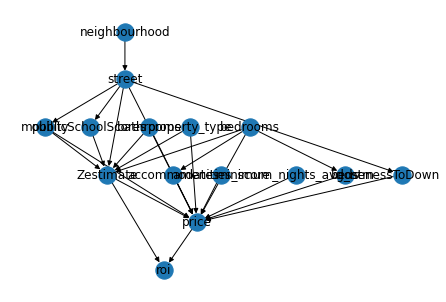

<Figure size 14400x7200 with 0 Axes>

In [29]:
import networkx as nx
import pydot

DAG_11 = nx.DiGraph()
DAG_11.add_edges_from(edges)
pos_11 = nx.nx_pydot.graphviz_layout(DAG_11, prog='dot')
nx.draw(DAG_11, pos=pos_11, with_labels=True)
plt.figure(figsize=(200,100))
plt.show()

In [30]:
def adjacencyMatrix(edges):
    df = pd.DataFrame(edges, columns =['source','target'], dtype = float) 
    df = pd.crosstab(df.source, df.target)
    idx = df.columns.union(df.index)
    df2 = df.reindex(index = idx, columns=idx, fill_value=0)
    df2.index.name = "source"
    df2 = df2.rename_axis('target')
    return df2

In [31]:
adjMat = adjacencyMatrix(edges)

In [ ]:
adjMat

In [32]:
data_discrete = data_discrete.astype(object)
model ={'adjmat':adjMat, 'model':graph}

model_update = bnlearn.parameter_learning.fit(model, data_discrete, verbose=1)

In [33]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

now = 2020-12-09 21:36:36.697865
date and time = 09/12/2020 21:36:36
